In [1]:
import numpy as np
import os
import random
import scipy
from scipy.interpolate import griddata
from scipy import signal
from numpy.fft import fft

import pandas as pd
import pickle

import seaborn as sns
sns.set(font='Yu Gothic')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [46]:
Fs = 128
channels = ['EEG.Cz', 'EEG.FCz',
       'EEG.Fz', 'EEG.Fp1', 'EEG.F7', 'EEG.F3', 'EEG.F1', 'EEG.C1', 'EEG.C3',
       'EEG.FC3', 'EEG.T7', 'EEG.CP3', 'EEG.P1', 'EEG.P3', 'EEG.P7', 'EEG.O1',
       'EEG.CPz', 'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.P8', 'EEG.P4', 'EEG.P2',
       'EEG.CP4', 'EEG.T8', 'EEG.FC4', 'EEG.C4', 'EEG.C2', 'EEG.F2', 'EEG.F4',
       'EEG.F8', 'EEG.Fp2']

In [47]:
def csv_listdir(path):
    return [tmp for tmp in os.listdir(path) if ".csv" in tmp]

# firフィルタを適用する
def firFilter(x):
    # fir filter
    b = signal.firwin(511, [1.0/(Fs/2), 15.0/(Fs/2)], pass_zero=False)
    x[:, :-1] = signal.filtfilt(b, 1, x[:, :-1], axis=0)
    return x

# triggerからNポイント抽出する
n = 128
def triggerExtract(x, trigger):
    triggers = np.where(x[:, -1] == trigger)[0]
#     print(trigger, "：", len(triggers))
    result = np.zeros((len(triggers), n, x.shape[1]))
    i = 0
    for tmp in triggers:
        tmp = x[tmp:tmp+n].reshape([1, -1, x.shape[1]])
        if tmp.shape[1] == n:
            result[i] = tmp
            i += 1
    return result

# 複数のトリガーを取得
def triggersExtract(x, triggers):
    target = triggerExtract(x, triggers[0])
    for num in triggers[1:]:
        target = np.concatenate([target, triggerExtract(x, num)], axis=0)
    return target

# 波形の加算平均をとる
def WaveAverage(x):
    result = np.zeros((x.shape[1], x.shape[2]))
    for i in range(x.shape[0]):
        result += x[i]
    result = result / x.shape[0]
    return result[:, :14]

def plot_average(target, nontarget):
    target_ave = WaveAverage(target)
    nontarget_ave = WaveAverage(nontarget)
    tt = np.linspace(0, 1, target.shape[1])
    channel = 15
    plt.figure(figsize=(24, 18))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    for i in range(len(channels)):
        plt.subplot(8, 4, i+1)
        plt.plot(tt, target_ave[:, i], 'r', label="target")
        plt.plot(tt, nontarget_ave[:, i], 'b', label="nontarget")
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.xlabel("Second[s]")
        plt.ylabel("Amplitude[μV]")
        plt.ylim(-12, 15)
        plt.title(channels[i], fontsize=18)
    plt.show()

In [2]:
os.listdir("201029_data_exp1")

['hand1_1_29.10.20_14.18.33.csv',
 'hand1_29.10.20_13.51.25.csv',
 'hand1_2_29.10.20_14.23.07.csv',
 'hand1_3_29.10.20_14.28.13.csv',
 'hand1_4_29.10.20_14.50.14.csv',
 'hand1_5_29.10.20_14.55.03.csv',
 'readme.txt']

In [40]:
def load_data(path):
    x = pd.read_csv(path, skiprows=1)
    x = x.values
    index = list(range(3, 3+32))
    index.append(41)
    x = x[:, index].astype(np.float)
    return x

In [63]:
X = load_data("201029_data_exp1/hand1_1_29.10.20_14.18.33.csv")
X.shape

(22818, 33)

In [64]:
x0 = triggerExtract(X, 0)
x0.shape

(10, 128, 33)

(1024, 2048)

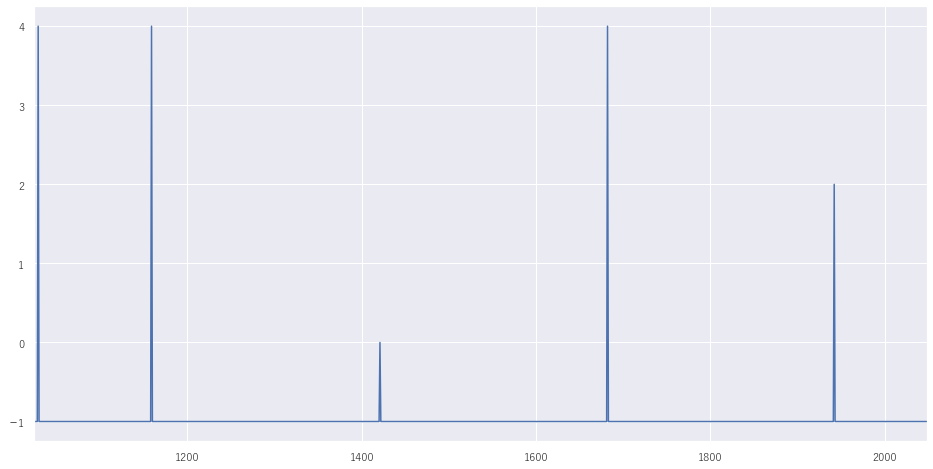

In [73]:
X[np.isnan(X)] = -1
plt.figure(figsize=(16, 8))
plt.plot(X[:, -1])
plt.xlim(1024, 2048)